<h1 align='center'>Cyberbullying Detection</h1>
<img src="cyber-bullying.jpeg" alt="Alternative text" width=500 height=200/>

# Abstract
With rise of social media coupled with the Covid-19 pandemic, cyberbullying has reached all time highs. We can combat this by creating models to automatically flag potentially harmful tweets as well as break down the patterns of hatred.

# About this dataset
This dataset contains more than 47000 tweets labelled according to the class of cyberbullying:

Age<br>
Ethnicity<br>
Gender<br>
Religion<br>
Other type of cyberbullying<br>
Not cyberbullying<br>
The data has been balanced in order to contain ~8000 of each class.

# Bussiness Constraints 
No low-latency contraints<br>
Interpretability is partially important<br>
Probability of class predicted is important so we can tune prob_score if required in production.

#  Mapping the real-world problem to an ML problem¶
### 1) Type of Machine Learning Problem:
    Since there is 6 different classes a query can belong it is a multiclass classification problem.
### 2) Performance Metric
    Multiclass-LogLoss
    Confusion Matrix 

# How to use this dataset
Create a multiclassification model to predict cyberbullying type<br>
Create a binary classification model to flag potentially harmful tweets<br>
Explore words and patterns associated with each type of cyberbullying.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import spacy

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

from os import path
import warnings
warnings.filterwarnings("ignore")

In [2]:
# reading the data
df = pd.read_csv("cyberbullying_tweets.csv")
print("Number of rows in the data: ", df.shape[0])
print("Number of columns in the data: ", df.shape[1])

Number of rows in the data:  47692
Number of columns in the data:  2


In [3]:
df.head()

tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [5]:
print("Number of duplicated rows in the dataset :",df.duplicated().sum())
df[df.duplicated()]

Number of duplicated rows in the dataset : 36


tweet_text cyberbullying_type
1758   Our pancakes are selling like hotcakes Shaz - ...  not_cyberbullying
3833   But you all respect him....Pete hasn't read tw...  not_cyberbullying
3939   This is the opportunity to prove ourselves lik...  not_cyberbullying
5684   Strategicscoring should be classed as cheating...  not_cyberbullying
6975   If we're at the bottom of the leaderboard, we'...  not_cyberbullying
7227   It wouldn't be fair. Kat knows NOTHING of fair...  not_cyberbullying
7278   @TVWEEKmag: There is only 1 way to stay in the...  not_cyberbullying
7822   @Ima_TV_Junkie: What the hell were Annie and L...  not_cyberbullying
9672   @victorymonk: #sorryitsaboy joke means more bo...             gender
9835   @thisonesakillaa: In my opinion? All jokes are...             gender
11076  Simple things please simple minds. @pumpkinkin...             gender
12664  No offense. @NigelBigMeech I'm not sexist but ...             gender
12695  raped is not a synonym for "touched" @magconbo...             gender
12714  @Transic_nyc: What do u think her punishment s...             gender
12789  girls @Dehner07 In usually not sexist, but gir...             gender
12851  We've proven we're not just dumb blondes and p...             gender
13396  We proved that we're not just pretty faces. Oh...             gender
13830  @ErikssonMalin85: #QuestionsForMen ever walked...             gender
13839  We want everyone to know we are not just prett...             gender
13859  girl sports gives it away here @LM26_LYE_ERA I...             gender
14102  Females and "guys." @AwkwardEP I'm not sexist ...             gender
14222  @nethercott_eden: Why is #WomenAgainstFeminism...             gender
14235  I'm not sexist, except when I am. @gentlemanby...             gender
14286  I'm not sexist, there are women everywhere! @d...             gender
14516  Women's bathrooms are so much worse than men's...             gender
14760  @ErikssonMalin85: Have u ever expressed ur ang...             gender
15018  Radical? lol no @David_i_think Call me sexist....             gender
15420  @MHWitchfinder: Please, if you disagree with H...             gender
15422  I'm not sexist, I just become instantly virule...             gender
15572  @botticellicream: I'm curvy. The kind men fap ...             gender
15839  We're not just the dumb blondes with the prett...             gender
15849  just don't = the sum total of your unconscious...             gender
15887  @fee_bee_63: Kat is a completely rank cow but ...             gender
20604  A Pakistani court has sentenced 86 members of ...           religion
46962  Still, Davis, who is gay, said he pays a socia...          ethnicity
47397  Racism won't stop as long as u stil select ur ...          ethnicity

In [6]:
df.drop_duplicates(inplace=True)
print("Number of duplicated rows in the dataset :",df.duplicated().sum())

Number of duplicated rows in the dataset : 0


<AxesSubplot:>

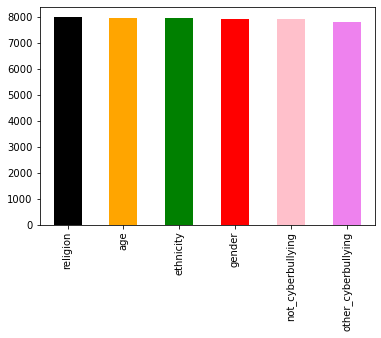

In [7]:
c = ['black','orange','green','red','pink','violet','yellow']
df['cyberbullying_type'].value_counts().plot.bar(color=c)

### so we can see that the class labels are well balanced 

In [8]:
# code to remove emojis from text 
# code by Denis da Mata -- https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
text = '✌️sure.. thanks 🙂'
print(text) # with emoji
emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030""]+", re.UNICODE)
print(emoj.sub(r'', text)) # no emoji

✌️sure.. thanks 🙂
sure.. thanks 


In [9]:
#code for removing weburls from text -- self coded
#text = "Education Nation: http://localhost:8888/notebooks/AppliedML/cyberbulling/Untitled.ipynb Bullying Turn to 10 http://t.co/sxTIWtp"
#if "http" in text:
#        runs = len(re.findall('http', text))
#        for i in range(runs):
#            sindex = text.find("http")
#            eindex = text.find(" ", sindex)
#            text = re.sub((text[ sindex : eindex ]),"",text)  
#print(text)

## removing emojis
## removing web urls
## Removing username that start with @ symbol
## removing the words other than english
## punctuations and shortcut words removal
## lower case conversions 
## remove if len of word is less than 2
## stop_word removal
## stemming

# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def text_preprocess(row):
    string=''
    text_raw = row['tweet_text']

    # removing emojis
    text_emoj = emoj.sub(r'', text_raw)
    
    #removing parantheses from tweet_text
    text_emoj = text_emoj.replace("]","").replace("[","").replace("(","").replace(")","").replace("{","").replace("}","")
    
    # removing web urls
    if "http" in text_emoj:
        runs = len(re.findall("http", text_emoj))
        for i in range(runs):
            sindex = text_emoj.find("http")
            eindex = text_emoj.find(" ", sindex)
            text_emoj = re.sub((text_emoj[ sindex : eindex ]),"",text_emoj)  
            
    # Removing username that start with @ symbol
    runs = len(re.findall("@", text_emoj))
    for i in range(runs):
        sindex = text_emoj.find("@")
        eindex = text_emoj.find(" ", sindex)
        text_emoj = re.sub((text_emoj[ sindex : eindex ]),"",text_emoj)
    
    # punctuations and special characters removal 
    text_emoj = text_emoj.replace("'","").replace("\"","").replace("!","").replace("#","").replace("?","").replace("$","dollar ")\
    .replace(":","").replace(";","").replace("*","").replace("^","").replace("%","").replace("~","").replace("`","")\
    .replace("&","").replace("<","").replace(">","").replace(",","").replace("+","").replace("|","").replace("-","")\
    .replace("/","").replace(".","").replace("=","").replace("_","").replace("'m'"," am ").replace("'s'"," is ")\
    .replace("'re'"," are ").replace("'ll'"," will ").replace("'d'"," would ").replace("'m'"," am ").replace("n't"," not ")\
    .replace("'ve"," have ")
    
    # removing the words other than english and convert to lowerclass
    ps = PorterStemmer()
    text_clean = ''
    for x in text_emoj.split(" "):
         # stop_word removal
        if x not in stop_words:
            if re.search(r"([a-zA-Z]+)",x):
                if len(x)>2:
                    # stemming using NLTK library
                    x = ps.stem(x.lower())
                    text_clean = text_clean + " " + x
    
    # return NAN if len of each text is less than 2
    if len(text_clean) < 3:
        return float('nan')
    else:
        return text_clean

In [10]:
df['text_preprocessed'] = df.apply(text_preprocess,axis=1)

In [11]:
def print_text(row):
    print(row['tweet_text'])
df.apply(print_text,axis=1)

In other words #katandandre, your food was crapilicious! #mkr
Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc
@XochitlSuckkks a classy whore? Or more red velvet cupcakes?
@Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.
@RudhoeEnglish This is an ISIS account pretending to be a Kurdish account.  Like Islam, it is all lies.
@Raja5aab @Quickieleaks Yes, the test of god is that good or bad or indifferent or weird or whatever, it all proves gods existence.
Itu sekolah ya bukan tempat bully! Ga jauh kaya neraka
Karma. I hope it bites Kat on the butt. She is just nasty. #mkr
@stockputout everything but mostly my priest
Rebecca Black Drops Out of School Due to Bullying:
@Jord_Is_Dead http://t.co/UsQInYW5Gn
The Bully flushes on KD http://twitvid.com/A2TNP
Ughhhh #MKR
RT @Kurdsnews: Turkish state has killed 241 children in last 11 years http://t.co/JlvkE1epws  #news  ##Googl

@KleptoKevin You should probably have your hearing checked. If higher frequencies have excessive volume to you you may have hearing loss.
Seriously don't understand how #thehobbit can be parted into three movies. It's barley one, if you compare w the lotr books.
Little man starting a new daycare today so I played beans for him so he can be on his broad street bully shit #NCT
We mostly hear about harassment in the context of GamerGate, but that's a very narrow focus and not the real problem.
Amazon has selection, decent prices, overall good customer experience. but their user interface has been a hot mess for forever.
#mkr scoring is ridiculous. "Liked 80% of it so only giving a 4" #snakes
@wtochetto kkkk' Jesus aprova o Bullying
You've got to be fucking kidding me. @halletecco @wadhwa @Jason
@asem_1994 Pact of Umar. http://t.co/VPpG4M9iV3 Should we make Muslims in the west live by such a pact in reverse?
+men are "biologically hardwired to like it", thanks for draining my faith in huma

Yup It's a wile that I wasn't Online But geus what... I didn't miss anything &gt;&gt;&gt; #Enjoyofyourlife  #Peaceout !! #mwuuah
@ChannyBH @tania_price72
Bullying & body language advice http://t.co/H0yfAN6
@iiSpeakKindness i don't remembering asking you when you had to be back to school .....
Another ad. Seriously? #mkr
We're going camping on #MKR, or as Ash &amp; Camilla would prefer -#GLAMPING ! Breakfast for 200? No worries! http://t.co/e57hV6hMXz
@bullysteria de la chingada mi bully, yo perdí la fe hace mucho tiempo ya me canse pero no puedo hacer que pare #pesadilla.
@ItzLeemah where do you stay and what school do you attend ?
@cigardubey right now? multiple browsers :P   i should set up tweetdeck for this.
Frio é bullying contra os solteiros. http://t.co/qATI3Jw
@RaikonL @finaleve @mja333 WHY DO YOU HATE FREEDOM
@PeerWorker yes. given that one group routinely posts mutilated bodies on twitter along with american passports, i'd say they are worse.
Would anybody be shocked if this 

@halalflaws I don't see your 33:33. Only something about a house and can't breath. What does that have to do with 33:33.
Lol hot box on a red light !🙉💨💨🚦
RT @voretaq7: .@freebsdgirl Yes, that's what I want in a Valentine: Morbid self-destructive obsession with my demise. #FearTheCreepyOnes
It's cool. I'm sure @wadhwa is going to say NPR was just calling him out for the attention, right?
RT @the_author_: "Oh, you're mad that I called you a [gendered slur]? See! Women are so unreasonable!" Yep, that's totally why women experi…
@danhazelton_ Maybe you should not commentate on the twitter
I been stalking the clock since 7:09 this morning
@Mayi_FirstClass FOLLOW ME
@videogame554 "No one is saying shit"? ARE YOU EVEN ON THIS PLANET
@MissKellyO giving your kids names like that is just asking for them to be bullied in school.
#MKR why are all tonight's contestants dressed like they are going on dancing with the Stars?
@IAMQUEENLATIFAH Ck us out www.hbhliveapparel.com Sending out a positive mes

@cbleiker #GermanProfessor gives meaning to term FemiNazi.Doesn't hire "Indian Men" bcz of "Indias's Rape Problem"
RT @BlissTabitha: Feminazi Blog Reminds Liberals Today Is “National Day of Appreciation for Abortion Providers”… http://t.co/G4EqVuuKoo
Hollywoods newest Feminazi movie remake will be titled "Ben Her".~Me
Is there anything such as an inappropriate joke, even for a comedian? Roxane Gay certainly thinks so. She says, “If rape is funny, (then) gang rape is funnier.” “Rape humor is designed to remind women that they are still not quite equal.” Deep.
Please do! @TomFordyce1 Women's t20 cricket, I'm not sexist but I'd rather kick myself in the eye
.@ListenToRaisin Never said "men are smarter". I said feminists are stupid. Most women are not feminists. But 100 answers... I'll focus on 2
👧👧 yes it is
Liberal female reporter calls Press Secretary Kayleigh a "lying bitch" really throw her sorry ass out.
The Miseducation of the American Boy Why boys crack up at rape jokes, think havi

Gay and rape jokes are all I make now kill me
the world is really full of toxic ppl. There’s someone who make a joke about being RAPE. And he said its fine because he’s a guy? BRUH GIRL,BOY,LESBIAN, OR GAY WHAT EVER YOU ARE ITS NEVER ACCEPTABLE TO MAKE A JOKE ABOUT RAPE.
#MileyCyrus Miley Cyrus causes controversy with date-rape 'joke' at GAY club gig in London http://ift.tt/1jm2uyJ
@antifempsycho2 Not in the EU...
hot take for y’all on this fine afternoon: - gay is not an insult - let the f- slur die - rape jokes aren’t funny - the r-word is not okay to use as an insult - catcalling isn’t a compliment - non-black ppl using the n-word need to stop - no means no
I know good and damn well a lot of you females watching the video and in y’all mind y’all saying “ alright, i ain’t gonna call her no bitch, but......” I ain’t got respect for nobody that agree with that behavior.
@TrainInVainn Your defense of a gender biased prison system...?
See you GF week #mkr for the real stuff #boring #imdo

can u believe that today I was in the presence of some1 who used gay as an insult AND said a rape joke
I never ever said that. But hey bro you wanna call females a bitch Bc you had a bad day than go for it I’m not the root of your problem
@seanbedllam should I avoid your show if i find fat jokes, gay jokes, rape jokes, sexist jokes or any of their kin offensive?
I hope these blonde girls make it thru, not great cooks but they aren't as judgemental as that WA lady #MKR
Some jokes require an apology in my opinion. Beating gay children is one example for me. Is there anything that offends you? Jokes about your race? Your religion? Your appearance? Rape? Incest? I mean we each decide where we draw the line. Beating gay children is a line for me.
Tonight's #MKR confirms the casting people trawl the dark depths of the seriously delusional, the supremely misguided &amp; plain rotten cooks.
The GOP, Trump turn any flaw in legit arguments to Fake News! & issues of PC..then real rape &amp; sick 

@etsho127 @SumerSloan @PAWarnhoff I made ISIS rise? What are you talking about. Islam created that monster. http://t.co/Q87IjKbd7q
RT @arrowsmithwoman: @sudixitca @KenRoth  It's a calculated Arab policy, to keep the Palestinians in a state of desperation to incite more …
Ask and check news. Islamic Terrorism is everywhere. My question why? Have u ever asked urself Y? Ask ur peers, ur Govt. Why Jaish-e-Muhammad, LeT, Islamic State? Do u know Pakistan has defamed Islam, think when u say JeM, LeT doesn't it sound bad, only Islam??
@sajid_fairooz @IsraeliRegime Yes they are Jew hating barbarians.
So the #NoBanAct is only good for Muslims and not for the people you Hollyweird idiots are trying to ban for having an opinion that does not match yours.
Μοst of the "Radical Leftists/Communists (SYRIZA party)" and the true Communists (KKE party) really hate all Christian Churches and want to see Christianity in general destroyed. #ANTIFA in Greece would not be so bold if they did not enjoy widesp

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




You already said its different.. Black people are dying over racism and you're talking of white people racism that doesn't let them say nigger with what is in the news It's a disgusting pick me with a splash of be my master I'm a good black
I hope you get yo ass beat . Dumb broad “@kimberrlym_: Fuck you nigger #CANELOTEAM”
RT @tayyoung_ FUCK OBAMA, dumb ass nigger &lt;BITCH! KILL YOURSELF!!! NOWWWWW.
@FMbeltra @jnsanchez IF you believe ALL AMERICANS ARE PATRIOTS then ur the fucking idiot. Pulse Nightclub, San Bernardino, both killers 1of2
Anything with OBAMA on it TRUMP'S tried erasing. ALL PAST POTUS Worked together. Remember PAPA BUSH, CARTER, CLINTON, BUSH, OBAMA they held a FUND Raiser telethon for the HURRICANES, They invited Trump to join them He said NO. THE 4 ARE FRIENDS they helped their predecessors
Looks like the Washington DC "Negro," has turned on its Federal master. WEB DuBois wrote a history called "The Philadelphia Negro." He describes how they once had the catering bu

fuck some gucci.. niggers is DUMB.
Yall love suck our dick "dumb bitch" RT @marilyn_misery: The only thing worse then a #nigger are the white girls who date/fuck them.
How large is it? U ever did any investigation about the number? Discrimination on yellow colored people has been existing for hundreds of year in white world or cultures, it’s not right to throw the reasons of racism towards yellow people on ill-mannered tourists from my country
@ChristianMato breaking rules is breaking rules. Dumb niggers lol. PSU actually has kids that give a fuck. OSU are thugs.
I grew up in a very liberal but also white part of the US when there were a lot of commercials on TV from the United Negro College Fund—which is still called that—and parents and teachers had to tell kids that no matter what they saw on TV you cannot call people Negroes
From one Texan to another. You’re in East Texas, a part of Texas that is still “blind” to the times. I’m sure you don’t want to be called Honkie, or gringa/o o

0        None
1        None
2        None
3        None
4        None
         ... 
47687    None
47688    None
47689    None
47690    None
47691    None
Length: 47656, dtype: object

In [12]:
def print_text(row):
    print(row['text_preprocessed'])
df.apply(print_text,axis=1)

 word katandandr food crapilici mkr
 whi aussietv white mkr theblock imacelebrityau today sunris studio10 neighbour wonderlandten etc
 classi whore red velvet cupcak
 meh thank head concern anoth angri dude twitter
 thi isi account pretend kurdish account like islam lie
 ye test god good bad indiffer weird whatev prove god exist
 itu sekolah bukan tempat bulli jauh kaya neraka
 karma hope bite kat butt she nasti mkr
 everyth mostli priest
 rebecca black drop out school due bulli
nan
 the bulli flush
 ughhhh mkr
 turkish state kill children last year news googleçeviricitopluluğukürtçeyidee…
 love best respons hotcak manag film noncommitt meh adolesc mkr
 parem fazer bulli comigo uhahuah bando preto
 tadinhu mim sofrendo bull viu mimi
 twitter basic angri letter gener
 best pick line your cute love peopl call jame potter bulli mypatronusisy
 now gotta walk classss offici hate stupid bu system
 know saudi chase girl burn build
 kid love mohamad bin zay citi
 still jack amsterdam ciroc cro

 wikipedia say sanction food medicin tri microbrain
 meet left like sometim next week
 viewer poll support ban burka countri yesrt fav bantheburka htt…
 the self esteem act it time confront bulli that our beauti cultur
 instant restaur round mkr
 weve prove dumb blond pretti face whatev mkr
 hahaha
 compani sorri crazi year
 next year kitchen rule may eventu get past fuck instant restaur round mkr
 kurdish troop liber kirkuk oil worker sputnik intern iraq kurd isi hostag prisonersofwar
 that sloppi shit plate deconstruct realli give disast mkr
 heiii odah bsk msk yah jagain suheri yah jgn smp ijah kalap buat bulli suheri
 what gave histor research ever hear limit invent superstit
 are hope lot dead civilian serv propaganda goal
 bout hit picnic bull
 that entré look foul gtlt mkr
 kiosk select white bull bulli award finalist see
 lt3
 cgpa top student high school god
 lyn toni your wonder peopl well miss mkr
 what talk
 read manga friend text ask meet discuss project that okay guess
 m

 team actual care victim activ help reduc stigma speak
 coldplay inspir know alway
 wonder say
 until even danger worst thing ever happen mkr
 it time kitchen start now hungrycamp mkr
 that main look like bland mkr
 school till tuesday next week fuckya
 when marni think hotter school she wear black
 hate bot misconfigur po doesnt ebook name
 stay agre say
 lowest contest score seri mkr
 dude wait watch video youtub
 doe anyon give toss cesc join bulli boy barca
 ff last year chloe amp kelli kat amp andr channel doesnt like perth haha mkr
 havent start paper go class goodstud
 and endless chain reveng acceler chain reveng
 guess tri shove sanctimoni peopl cant read forehead
 feel son dick reebok one like like
 kati amp vikki request brevil sandwich maker ad kitchen mkr head quarter technicallychalleng mkr
 rofl good the huge isi attack dead daesh fertil land
 noooooooooooo mkr those vile cretin surviv
 adolescent diz que apanha \ncinco colega sete mese estudant diz ser vítima bulli que


 you dont seem understand could care less australian law
 race peopl would hate buddhism hinduism tao like hate islam but dont
 bat
 load philosoph bullshit
 time school bulli awar prevent mom dad parent health
 make succ diniccc til deh bitch hiccup amp call phinon ionn even piccup
 everytim someon score strateg come closer throw someth cheat omfg mkr
 javu tweet earli stage mkr vicki celin could kill bambi itll happen next week mkr
 there noth like blast keep wide awak hellyeah
 serenashim expos turkish govt help isis2day later killedmedia silent
 gosh how mani surpris announc show need mkr
 it realli fuck destroy brain tri come human utter base opinion deep
 ypgypj success late concern may get littl careless care good luck
 mkr there one grug stop tri kat
 bug
 beyond five translatorsher googl translat
 they highschool sweetheart nshit aint earli lol mezikan forev love
 pedo del regreso clase que regresara bulli nadi aguantar
 go get taylor swift new lay sick ass bed listen
 ignor s

 lot gay friend find rape joke hilari
 peopl like extra like peopl fuck joke rape gay one band member joke someth
 you know kat andr aw want kati nikki mkr
 ive wit firsthand rape someon wii remot but make gay joke judg
 what make role not much compar imagin tom cruis would made tripl
 thi dude beat women belittl vagina sexual want talk rape incest amp pedophil like it’ joke say gay mental ill then tweet dismantl toxic masculin nigga realli delusion
 longer put rape joke attack gay belittl poor peopl disregard middl class goodbyegop
 ummmmi friend like make gay joke thri rape one friend erri day lunch want bed
 idiot told man wear
 ye rape joke gay slur comedi fuck funni anyth hate ignor sign lazi write
 miley cyru ride blowup dick tell rape joke london gay club
 anoth thing gay ppl laugh gay joke let clarifi joke rape depress abandon that say whoa whoa
 and idiot token women stand around applaud anoth cruel nonsens move maga
 watch fifa pack open video morn gay joke rape joke reg kid 

 vice ganda sick gay cure dont overreact rape joke person issu
 year ago peopl make rape gay joke left right centr gunn dumbass he own sinc proven good person peopl stop pretend theyr perfect atleast level with
 sandler also profit recycl offens joke gay men and male survivor rape
 sexist anyth hope singl broad tri swerv woman ultim posit man…
 gotta love good gay rape joke less thn minut gameofthron thronesyal
 “grown ass man” think rape joke okay believ homosexu souli trauma gay gay assault defend predat and use word insult pull i’m nauseou
 think promot altfurri rape joke burn leftist shame flamboy gay men make unfavour comparison black women fine exclud net exclus drop not hard understand
 issu thing decri
 sometim wonder take far gay joke rememb guy friend tri rape feel much better
 veri true jesusreligion gay rape amp hiv joke never funni matter platform grow up”
 wtf kat andr cheater that unfair they cannot give someon they should gone mkr katandandr byeby bitch
 still fan ladi 

 yeah know still think make rape joke public unaccept ukip definit centreleft theyr extrem nationalist anti multicultur social traditionalist gay marriag pro death penalti etc climat chang denier rofl
 she ego kill end option beg juri mercysh refus nosoul
 there certainli accept time made though eye world larg also includ joke like rape gaybash etc shit tri watch friend seinfeld watch mani time throw gay peopl bu laugh
 pleas explain figur cite wage gap discuss compar thank
 wash dish make someth delici eat
 bro code never call femal bro famili hoe bitch
 need drink watch amp listen kat head mkr2015 mkr
 type femin googl autofil result sexist need
 when nigga call femal hi bitch that shit fuck disrespect could never
 rock much closer socrat know
 femal alway say nigga fuck anyth bitch fuck plastic call anoth femal nigga i’m delusion
 lack knowledg full display group racist rapist gay peopl nois much nois rape you think deepli chosen sexist homophob realli wise
 greasi hair colin judg m

 stolen valour chap categor assur classi youll probabl one idiot moan poppi muslim come novemb dont worri your sentiment wont worth shit arent proud veteran
 ever meet i’m buy ice cream assum christian woman like ice cream right
 guy one inform islam ive call muslim like downright idiot least couldv done inform name chang
 baat itni smjhana chah rahi generalis whole commun base individual’ act there mani idiot hindu mani stupid muslim religion you say muslim ais hote hai
 make love equip anoth good christian woman right ladi
 everi border islam share everi religion bloodi but suppos believ jew fault
 lol told support gobar gaumutra cure corona thi problem madrasachaap million islam extremist butcher non muslim still cant generalis terror islam idiot someth entir hindu commun gobar eat
 stop give idiot platform time day you’r provid materi islamophob live idioci also muslim use time tweet “ermagahdd yewkay mozlimz are extreme” take crap take amp one
 and lie western creat
 mani lie hill

 can say fuckin idiot muslim stupid isnt go
 erdogan absolut idiot i’m muslim uncondit support it christian right he’ serv islam respect religion muslim must you’r muslim don’t believ jwei christian
 support radic christian give saudi arabia and weapon sell murder muslim ten thousand civilian kill fail war afghanistan
 idiot think lost peopl longer vote stuf good proper socialist jew black muslim gravi train over
 it easi speak indianarmi but dont enough speak power speak islam terror first let aris strongest voic neg concept islam jihad
 tri good christian woman bed earli neighbor decid hour fight right window doesn’t love anymor she’ almost certain he’ cheat obvious listen whole thing
 are tri show hiw complet ignor come natur guess idiot would surpris learn muslim slave broker much world includ your pander moron
 human right campaign christian woman kidnap muslim via
 found page qanon maga idiot think jfk isn’t dead he’ tweet pro trump far right wing conspiracy’ jfk die it’ like cou

 human be ought understand irrespect terrorist claim stand jihad crusad white supremaci hindutva end result alway loss life batter famili amp orphan children may allah merci soul amp grant hidayah human
 don’t know bloodi idiot call rss terrorist organis basi have ever seen rss kill anyon forc some1 convert hinduism you know mani muslim christian countri one hindu major countri coz dont forc
 hate lot toward muslim sect actual disgust you’r liter better islamophob idiot point
 tyagi pandit come back lathicharg better program jihadi hoor seekingterrorist bokoharam isi taliban alqaeda treat human terrorist advoc jihad innoc jizya non believ use sword convert
 wait muslim burnt hindu men women children crime they hindu you love propaganda lie right probabl mad christian woman saif stomach cut etc call evid shat ran read
 sadia terrorist organisationit muslim memberspleas prove one human right violat commit bigger white idiotsy guy want take matter pleas dow bigger countri world
 lack brai

 what idiot noth bulli
 know onlin abus look like weve studi creat report publish find
 found perfect rental whi cant leas right
 meet left like sometim next week
 accord peter griffin two type peopl bulli nerd bulli fuck nerd
 stop say sass will put foot your ass mkr
 doesnt not bad thing said total disgust think know real bulli
 itreallymakesmemad friend bulli idiot think better anyon els
 blameonenotal
 beck step take album year award
 bitter geno
 cours got bulli everyon got bulli did get bulli you know got punch head
 incorrect great law enforc
 saw lt3 metafilt
 tri play fabl anniversari edit xbox one control work second then steam start tri call peopl wtf
 your wait respons approxim peopl sorri afk week respond soon
 bryce can kill himself that fuck disgust asshol hate him with all heart and soul
 fuck ryan wanna come eat
 least msm manag basic fact check like confus
 mana would legit retard drive car tell peopl made vienna sausag
 wowyour horribl fuck friend
 kind love command 

 meanwhil player
 hasnt wwe absolut fuck stupid
 yup
 sure
 thank
nan
 dollar shoot video
 releas mani tool possibl bsd licens
 you arent alon your never alon
 perhap manag search canon svn repo correct usernam would help goo…
 kill
 difficult sometim alway well receiv heavi attack sometim cant tell what troll
 that cannot hous way mkr
 lrt everyth ever
 the way titti sag milk done gone bad bitch promis aint coppin
 your bulli
 the fact peopl serious use word feminazi day gtgt
 oapi got mention kotaku
 alright time get internet hide bit manag sleep ill get gdc late tomorrow
 expos argentina suppos world class player
 launch missil syria are go war what the fck thi idiot offic coupl month alreadi
 snapchat chaotic evil post video drink vinegar piss peopl
 side note holi shit didnt know mani follow
 said like might want attribut year
 watch fox news bill oriley mention
 know report bulli
 jk jk actual real sad never play
 anyon play hero storm
 soon
 theyr bulli tbh
 ny tweet tripl sinc 

 well comment bulli say fat peopl need lose weight healthi matter fact
 whi evernot sell sock
 ill admit googl
 shouldv never elect presid fuck hate asshol
 dont like women refriger trope go say comic shouldnt exist
 tweetdeck gotten lot better final fix big blocklist bug
 someon said go attend supernova instead donat money ticket toward antibulli org thi
 full time
 dont know expect wasnt law and order tell give
 well info soon
 short need verifi isnt verifi requir govt id caus prob uniqu phone less problemat perfect
 lmfao dont kill bulli
 that basic org contact respond
 tell ugli ass friend lori hop phone
 pcbsd fork mostli fund ixsystem organ run freebsd market it frontend top freebsd
 see repli
 where file
 attack titan episod one end fuck
 lol use bulli
 too bad puxxi wont see none nigga gon scare
 ugh charact
 say mean bulli act like victim caught cant see theyr wrong bulli
 hate give bitch say text bitch
 thank peopl attack twitter well actual hate npr air episod
 mean ahead pl

 that girl left girl cri constantli caus bulli throughout high school scholar public school” caus didn’t speak english well yet chose grow experi right
 thi moment perfect descript girl knew high school one bulli gener weirdo determin becom korean everi way possibl even weird cringey shit crazi obsess annoy
 bill barr school bulli speak loudest overtop everyon els win
 agre keep hear parent say “i’m let school bulli kid wear mask social distancing” thi can’t allow continu need protect teacher student
 weird thing make friend post school meet new friend old friend realiz new friend would one girl bulli high school
 absolut floor situat autist boy name korvin seen video bulli harass group girl rowland high school these girl suspend day five day expel justiceforkorvin
 high school crazi bulli girl bulli treat victim mum involv mine
 it’ like bulli school grew went polic academi make offici
 y’all someon realli told don’t want advic someon ratchet ass eyebrow obvious hate work former high 

 the girl bulli high school tri harass via instagram long ago post pictur caption “a beauti insid outside” urg clap back fuck real lmao
 he grade school bulli he coward
 it’ weird peopl chang the high school bulli becam realli sweet humbl it’ like high sxhool never exist
 the girl bulli high school post someth mental health awar recent
 oldest come home beach immedi start pick youngest tell stop repli mom bulli home sinc he’ school toughen up” boy stupit hahaha nothingmean brotherlylov wealllaugh smartass boymom
 alway got bulli hang girl like femal pop artist like footbal gay funni part guy year school high school never care continu live life unboth lmfao
 bulli ever sinc grade school madalang lang tho also bulli minsan lang pero kahit minsan lang may naidudulot rin impact bulli apolog everyon bulli either physic verbal apolog letter bhie
 one thing realli need overcom fear swipe right girl look like would bulli high school
 one time high school told band girl play sampler attempt rel

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
print("Number of rows with null values after preprocessing : ",df.isnull().sum().sum())
df[df['text_preprocessed'].isna()]

Number of rows with null values after preprocessing :  408


tweet_text   cyberbullying_type  \
10                  @Jord_Is_Dead http://t.co/UsQInYW5Gn    not_cyberbullying   
31                           @KamilaaRudenko how are u ?    not_cyberbullying   
280                 @ANDAASONSAN https://t.co/dtjOHnRNhQ    not_cyberbullying   
307                                                   :D    not_cyberbullying   
394                         No u. http://t.co/zOr0eWahSS    not_cyberbullying   
...                                                  ...                  ...   
31626                            @DennisCEarl w not v ;)  other_cyberbullying   
31675  RT @korvys: @saintneko @freebsdgirl http://t.c...  other_cyberbullying   
31676                                            5/10/15  other_cyberbullying   
39780                             http://t.co/VyZeWBzBuF            ethnicity   
45086  --&gt; https://t.co/uQZekzKb8D https://t.co/UQ...            ethnicity   

      text_preprocessed  
10                  NaN  
31                  NaN  
280                 NaN  
307                 NaN  
394                 NaN  
...                 ...  
31626               NaN  
31675               NaN  
31676               NaN  
39780               NaN  
45086               NaN  

[408 rows x 3 columns]

In [14]:
#dropping null values from dataframe
df = df.dropna()
#dropping the original raw tweet_text
df.drop("tweet_text",axis=1,inplace=True)

# word cloud for text feature

In [16]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

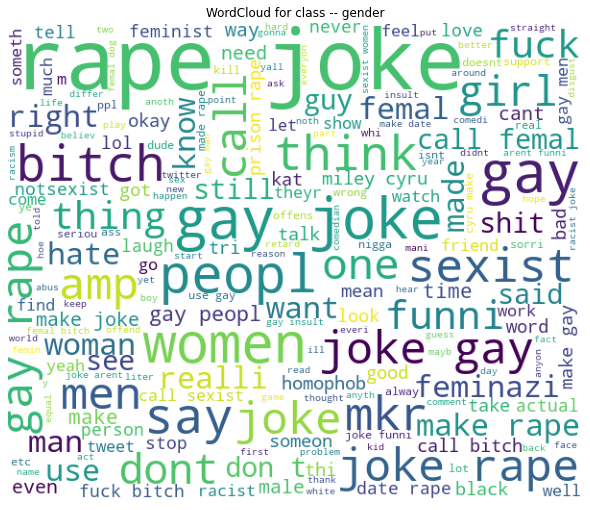

In [17]:
stopwords = set(STOPWORDS)
df_gender_text = ''
count = 0
for x in df[df['cyberbullying_type'] == 'gender']['text_preprocessed']:
    for y in x.split(" "):
        df_gender_text = df_gender_text+" "+ y
        count += 1
        

wordcloud = WordCloud(width = 600, height = 500,max_words=count,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df_gender_text)
 
# plot the WordCloud for class -- gender                     
plt.figure(figsize = (8, 8), facecolor = None)
plt.title("WordCloud for class -- gender")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

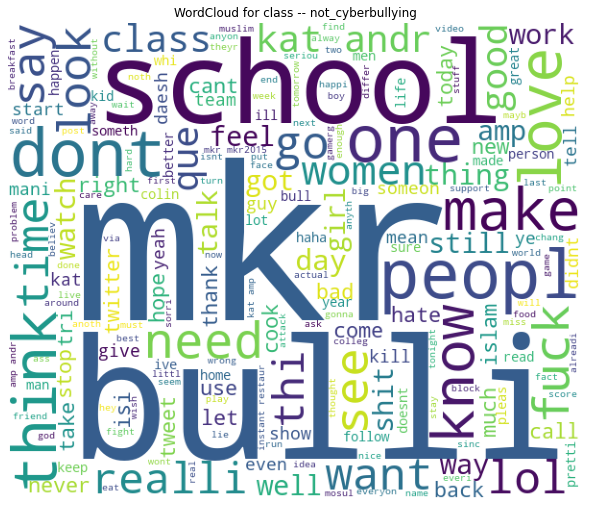

In [18]:
df_not_text = ''
for x in df[df['cyberbullying_type'] == 'not_cyberbullying']['text_preprocessed']:
    for y in x.split(" "):
        df_not_text = df_not_text+" "+ y

wordcloud = WordCloud(width = 600, height = 500,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df_not_text)
 
# plot the WordCloud for class -- not_cyberbullying                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.title("WordCloud for class -- not_cyberbullying")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

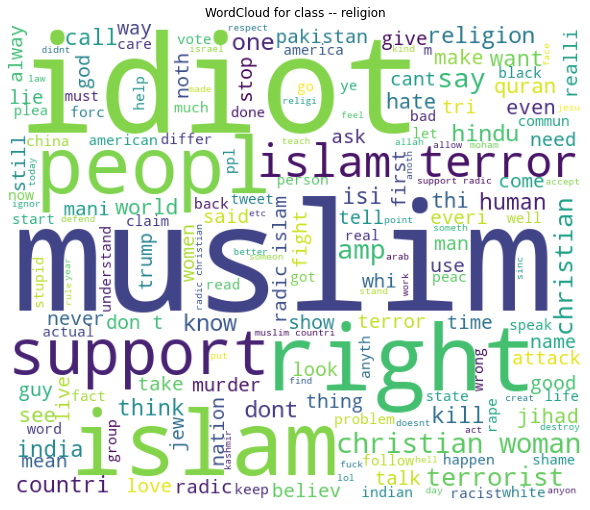

In [19]:
df_religion_text = ''
count = 0
for x in df[df['cyberbullying_type'] == 'religion']['text_preprocessed']:
    for y in x.split(" "):
        df_religion_text = df_religion_text+" "+ y
        count += 1
        
wordcloud = WordCloud(width = 600, height = 500,max_words=count,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df_religion_text)
 
# plot the WordCloud for class -- religion                    
plt.figure(figsize = (8, 8), facecolor = None)
plt.title("WordCloud for class -- religion")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

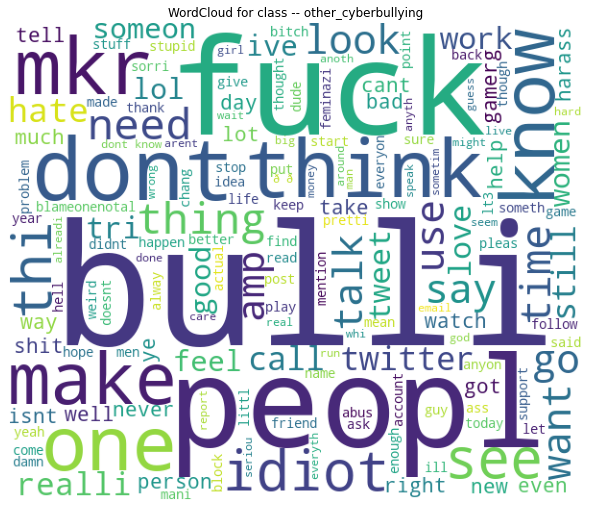

In [20]:
df_other_cyberbullying_text = ''
count = 0
for x in df[df['cyberbullying_type'] == 'other_cyberbullying']['text_preprocessed']:
    for y in x.split(" "):
        df_other_cyberbullying_text = df_other_cyberbullying_text+" "+ y
        count += 1
        
wordcloud = WordCloud(width = 600, height = 500,max_words=count,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df_other_cyberbullying_text)
 
# plot the WordCloud for class -- other_cyberbullying                    
plt.figure(figsize = (8, 8), facecolor = None)
plt.title("WordCloud for class -- other_cyberbullying")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

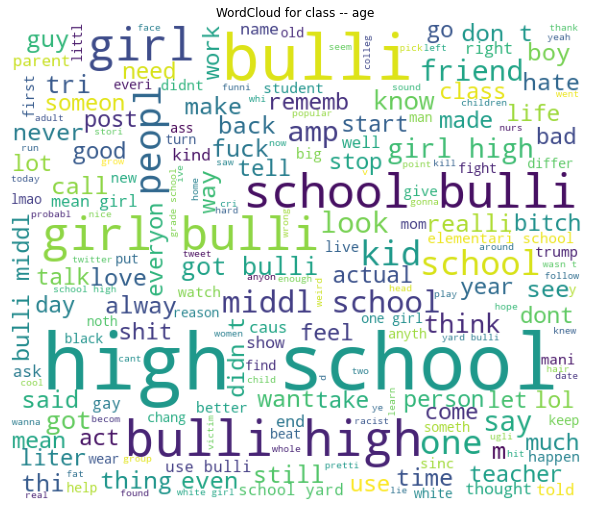

In [21]:
df_age_text = ''
count = 0
for x in df[df['cyberbullying_type'] == 'age']['text_preprocessed']:
    for y in x.split(" "):
        df_age_text = df_age_text+" "+ y
        count += 1
        
wordcloud = WordCloud(width = 600, height = 500,max_words=count,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df_age_text)
 
# plot the WordCloud for class -- age                    
plt.figure(figsize = (8, 8), facecolor = None)
plt.title("WordCloud for class -- age")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

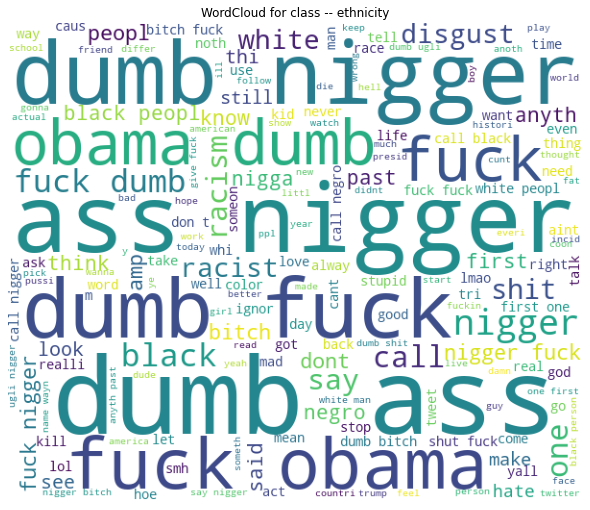

In [22]:
df_ethnicity_text = ''
count = 0
for x in df[df['cyberbullying_type'] == 'ethnicity']['text_preprocessed']:
    for y in x.split(" "):
        df_ethnicity_text = df_ethnicity_text+" "+ y
        count += 1
        
wordcloud = WordCloud(width = 600, height = 500,max_words=count,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df_ethnicity_text)
 
# plot the WordCloud for class -- ethnicity                    
plt.figure(figsize = (8, 8), facecolor = None)
plt.title("WordCloud for class -- ethnicity")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### <center> Observing all the results its sure that some words occur more frequently with different class labels and definitly helps in classifing the output class based on occurance of each word in that particular class field</center>

## Featurizing the text data

### 1) text length
### 2) number of token/word length
### 3) Bow with min_df = 3
### 4) tf-idf
### 5) word2vec
### 6) tf-idf weighted word2vec

In [17]:
# 1) text length
df['text_len'] = df['text_preprocessed'].apply(lambda x: len(x))

# 2) number of token/word length
df['text_word_len'] = df['text_preprocessed'].apply(lambda x: len(x.split()))

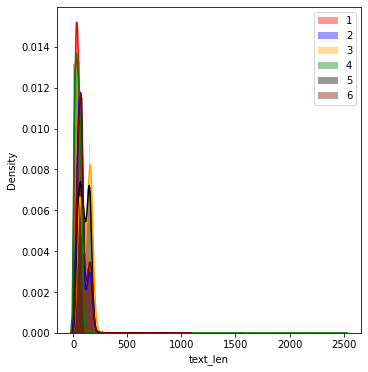

In [18]:
#Univariate analysis to check wether who much impotant is text_len and text_word_len features are
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.distplot(df[df['cyberbullying_type'] == 'not_cyberbullying']['text_len'] , label = "1", color = 'red')
sns.distplot(df[df['cyberbullying_type'] == 'gender']['text_len'] , label = "2" , color = 'blue' )
sns.distplot(df[df['cyberbullying_type'] == 'religion']['text_len'] , label = "3" , color = 'orange' )
sns.distplot(df[df['cyberbullying_type'] == 'other_cyberbullying']['text_len'] , label = "4" , color = 'green' )
sns.distplot(df[df['cyberbullying_type'] == 'age']['text_len'] , label = "5" , color = 'black' )
sns.distplot(df[df['cyberbullying_type'] == 'ethnicity']['text_len'] , label = "6" , color = 'maroon' )
plt.legend()
plt.show()

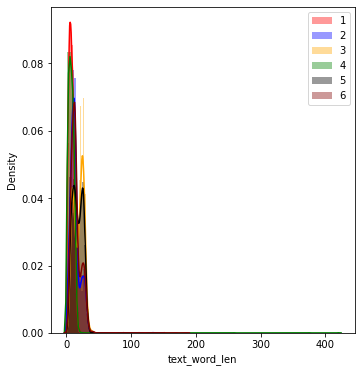

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.distplot(df[df['cyberbullying_type'] == 'not_cyberbullying']['text_word_len'] , label = "1", color = 'red')
sns.distplot(df[df['cyberbullying_type'] == 'gender']['text_word_len'] , label = "2" , color = 'blue' )
sns.distplot(df[df['cyberbullying_type'] == 'religion']['text_word_len'] , label = "3" , color = 'orange' )
sns.distplot(df[df['cyberbullying_type'] == 'other_cyberbullying']['text_word_len'] , label = "4" , color = 'green' )
sns.distplot(df[df['cyberbullying_type'] == 'age']['text_word_len'] , label = "5" , color = 'black' )
sns.distplot(df[df['cyberbullying_type'] == 'ethnicity']['text_word_len'] , label = "6" , color = 'maroon' )
plt.legend()
plt.show()

### <center> since all the features overlap almost exactly these features might not add much value and hence i am dropping these features</center>

In [20]:
df.drop(['text_len','text_word_len'],axis=1,inplace=True)

In [21]:
# 3) Bag Of Words
# building a CountVectorizer with all the words that occured minimum 3 times in train data
# in this case study i am skipping the ngram_range i.e... bigram and trigram and going with simple unigram and tfidf vectors
vectorizer = CountVectorizer(min_df=3)
X = vectorizer.fit_transform(df['text_preprocessed'])
print(len(vectorizer.get_feature_names()))

df_bow = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())

10223


In [22]:
df_BOW = df.merge(df_bow, left_index=True, right_index=True, how='left')
print("The shape of the dataframe after BOW : ",df_BOW.shape)

The shape of the dataframe after BOW :  (47248, 10225)


In [23]:
df_BOW.head()

cyberbullying_type                                  text_preprocessed   00  \
0  not_cyberbullying                 word katandandr food crapilici mkr  0.0   
1  not_cyberbullying   whi aussietv white mkr theblock imacelebritya...  0.0   
2  not_cyberbullying                     classi whore red velvet cupcak  0.0   
3  not_cyberbullying    meh thank head concern anoth angri dude twitter  0.0   
4  not_cyberbullying   thi isi account pretend kurdish account like ...  0.0   

    10  100  1000  100k  10k  10th  10x  ...  zimmerman  zine  zionism  \
0  0.0  0.0   0.0   0.0  0.0   0.0  0.0  ...        0.0   0.0      0.0   
1  0.0  0.0   0.0   0.0  0.0   0.0  0.0  ...        0.0   0.0      0.0   
2  0.0  0.0   0.0   0.0  0.0   0.0  0.0  ...        0.0   0.0      0.0   
3  0.0  0.0   0.0   0.0  0.0   0.0  0.0  ...        0.0   0.0      0.0   
4  0.0  0.0   0.0   0.0  0.0   0.0  0.0  ...        0.0   0.0      0.0   

   zionist  zoe  zombi  zone  zoo  zoomer  zynga  
0      0.0  0.0    0.0   0.0  0.0     0.0    0.0  
1      0.0  0.0    0.0   0.0  0.0     0.0    0.0  
2      0.0  0.0    0.0   0.0  0.0     0.0    0.0  
3      0.0  0.0    0.0   0.0  0.0     0.0    0.0  
4      0.0  0.0    0.0   0.0  0.0     0.0    0.0  

[5 rows x 10225 columns]

In [24]:
# label encoding the target feature 
labelencoder=LabelEncoder()
df_BOW['cyberbullying_type']=labelencoder.fit_transform(df_BOW['cyberbullying_type'])

In [25]:
# analysis to check who much impotant is BOW features in classifying 
# since the number of features obtained from BOW is 10223, instead of using univariate analysis we just build a model
# on these feature. if the model predicts better than a random model we can surely come to conclusion these feature helpful
print("Number of null values after BOW : ",df_BOW.isna().sum().sum())
df_BOW = df_BOW.dropna()
print("dataset shape after droping null ", df_BOW.shape)
x = df_BOW.drop(['cyberbullying_type','text_preprocessed'],axis=1)
y = df_BOW['cyberbullying_type']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

Number of null values after BOW :  4528789
dataset shape after droping null  (46805, 10225)


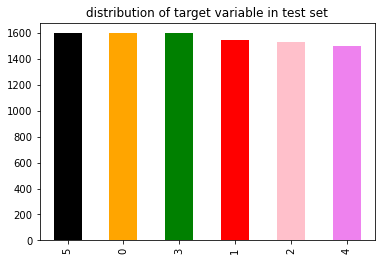

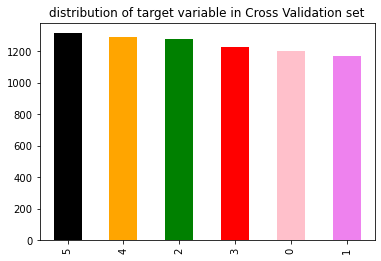

In [26]:
plt.title("distribution of target variable in test set")
y_test.value_counts().plot.bar(color=c)
plt.show()
plt.title("distribution of target variable in Cross Validation set")
y_cv.value_counts().plot.bar(color=c)
plt.show()

In [27]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    labels = [1,2,3,4,5,6]
    # representing A in heatmap format
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

# Random Model

In [28]:
# so we are building a random model first as our KPI is Log-loss
test_len = len(y_test)
rand_pred_prob = []
rand_pred = []
for x in range(test_len):
    a = list(np.random.rand(1,6)[0])
    rand_pred_prob.append(a)
    rand_pred.append(np.argmax(a))

In [29]:
# multiclass logloss for random model
print("Log-Loss for Random model is : ", log_loss(y_test,rand_pred_prob))

Log-Loss for Random model is :  2.069582776045319


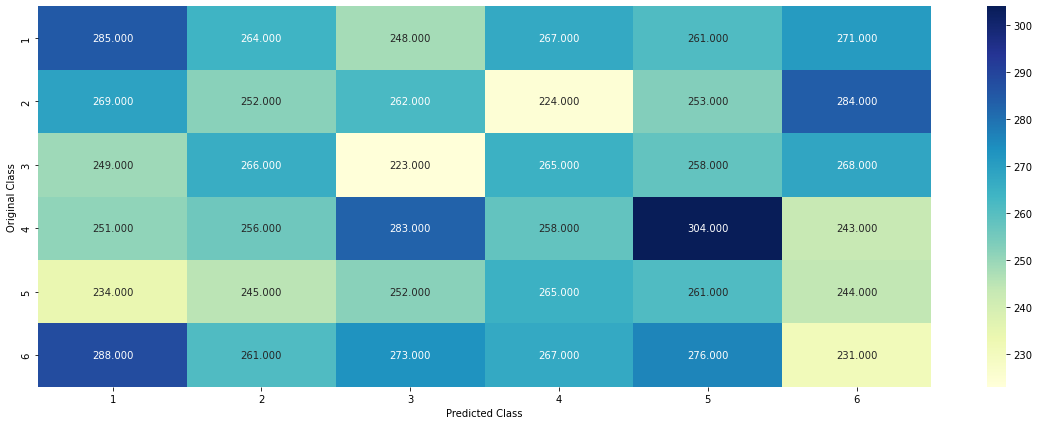

In [30]:
plot_confusion_matrix(y_test,rand_pred)

# Deriving the tfidf vectors 

In [36]:
vectorizer = TfidfVectorizer(min_df=3)
X = vectorizer.fit_transform(df['text_preprocessed'])
print(len(vectorizer.get_feature_names()))

df_tfidf = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())

df_TFIDF = df.merge(df_tfidf, left_index=True, right_index=True, how='left')
print("The shape of the dataframe after BOW : ",df_TFIDF.shape)

10223
The shape of the dataframe after BOW :  (47248, 10225)


# TF-IDF weighted WORD2VEC

In [44]:
# dict key:word and value:tf-idf score (to use this while )
word2tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_lg')
#example of converting a word to vector
x=nlp('man')
x.vector.shape

(300,)

In [45]:
vecs2 =[]
for txt in list(df['text_preprocessed']):
    doc2 = nlp(txt.strip())
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector

        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0

        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)

In [46]:
df['text_w2v'] = list(vecs2)

## <center>Training a simple Naive Bayes to only on BOW features.

In [31]:
alphaNB = [10**x for x in range(-3,8)]
lossMNB = []
for i in alphaNB:
    #naive bayes model
    MNB = MultinomialNB(alpha=i)
    MNB.fit(x_train,y_train)
    
    #calibarated classifiers for getting the actual probability score
    sig_clf = CalibratedClassifierCV(MNB, method="sigmoid",n_jobs=5)
    sig_clf.fit(x_train,y_train)
    MNB_probs = sig_clf.predict_proba(x_cv)
    
    #append the loss for different alpha value
    lossMNB.append(log_loss(y_cv, MNB_probs, eps=1e-15))
    print("Log-Loss for alpha value ", i , " is : ",log_loss(y_cv, MNB_probs, eps=1e-15) )

Log-Loss for alpha value  0.001  is :  0.8590790562231831
Log-Loss for alpha value  0.01  is :  0.8204299849346873
Log-Loss for alpha value  0.1  is :  0.7807301312456013
Log-Loss for alpha value  1  is :  0.7533021833277167
Log-Loss for alpha value  10  is :  0.7807879074903642
Log-Loss for alpha value  100  is :  0.7746259947514674
Log-Loss for alpha value  1000  is :  0.7482413678966522
Log-Loss for alpha value  10000  is :  0.8035093661072923
Log-Loss for alpha value  100000  is :  0.80882272398103
Log-Loss for alpha value  1000000  is :  0.8017098124720394
Log-Loss for alpha value  10000000  is :  0.8060466284826215


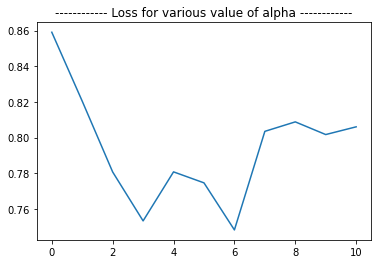

In [32]:
plt.title("------------ Loss for various value of alpha ------------")
plt.plot(lossMNB)
plt.show()

In [33]:
print("the least value of log-loss is ",min(lossMNB),"with the best value for alpha is : ", alphaNB[np.argmin(lossMNB)])

the least value of log-loss is  0.7482413678966522 with the best value for alpha is :  1000


In [34]:
# training model with best alpha value
MNB = MultinomialNB(alpha=1000)
MNB.fit(x_train,y_train)

sig_clf = CalibratedClassifierCV(MNB, method="sigmoid",n_jobs=5)
sig_clf.fit(x_train,y_train)

MNB_probs_train = sig_clf.predict_proba(x_train)
MNB_probs_cv = sig_clf.predict_proba(x_cv)
MNB_probs_test = sig_clf.predict_proba(x_test)

print("Log-Loss for train data : ",log_loss(y_train, MNB_probs_train, eps=1e-15) )
print("Log-Loss for cross validation data : ",log_loss(y_cv, MNB_probs_cv, eps=1e-15) )
print("Log-Loss test data : ",log_loss(y_test, MNB_probs_test, eps=1e-15) )

Log-Loss for train data :  0.7280310912304182
Log-Loss for cross validation data :  0.7482413678966522
Log-Loss test data :  0.7476431184155826


### <center> The log loss is significantly much less than our random model which is a good sign, also since the loss for Train, Cross validation and Test data set are roughly same we can say the model is well trained i.e... neither it is overfiting or underfitting

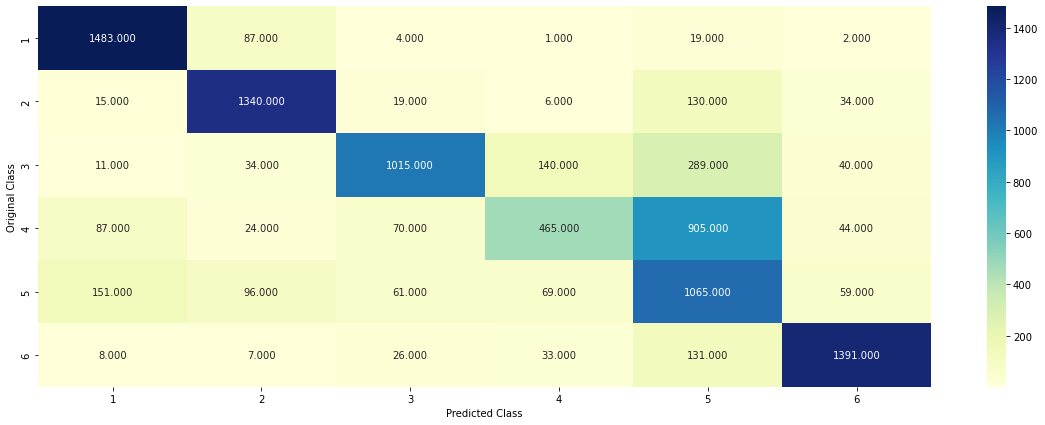

In [35]:
MNB_pred_test = []
for i in MNB_probs_test:
    MNB_pred_test.append(np.argmax(i))
plot_confusion_matrix(y_test,MNB_pred_test)

### <center>Here we can see a drastic imporvement in the model compared to the random model i.e... the number of correct predictions have increased significantly.

## <center>Training a simple Naive Bayes only on TF-IDF features.

In [37]:
# label encoding the target feature 
labelencoder=LabelEncoder()
df_TFIDF['cyberbullying_type']=labelencoder.fit_transform(df_TFIDF['cyberbullying_type'])

In [38]:
# analysis to check who much impotant is if-idf features in classifying 
# since the number of features obtained from tf-idf is 10223, instead of using univariate analysis we just build a model
# on these feature. if the model predicts better than a random model we can surely come to conclusion these feature helpful
print("Number of null values after BOW : ",df_TFIDF.isna().sum().sum())
df_TFIDF = df_TFIDF.dropna()
print("dataset shape after droping null ", df_TFIDF.shape)

x = df_TFIDF.drop(['cyberbullying_type','text_preprocessed'],axis=1)
y = df_TFIDF['cyberbullying_type']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

Number of null values after BOW :  4528789
dataset shape after droping null  (46805, 10225)


In [39]:
alphaNB = [10**x for x in range(-3,8)]
lossMNB = []
for i in alphaNB:
    #naive bayes model
    MNB = MultinomialNB(alpha=i)
    MNB.fit(x_train,y_train)
    
    #calibarated classifiers for getting the actual probability score
    sig_clf = CalibratedClassifierCV(MNB, method="sigmoid",n_jobs=5)
    sig_clf.fit(x_train,y_train)
    MNB_probs = sig_clf.predict_proba(x_cv)
    
    #append the loss for different alpha value
    lossMNB.append(log_loss(y_cv, MNB_probs, eps=1e-15))
    print("Log-Loss for alpha value ", i , " is : ",log_loss(y_cv, MNB_probs, eps=1e-15) )

Log-Loss for alpha value  0.001  is :  0.9376784950072679
Log-Loss for alpha value  0.01  is :  0.8656775424820106
Log-Loss for alpha value  0.1  is :  0.7857608230359173
Log-Loss for alpha value  1  is :  0.7183177570161317
Log-Loss for alpha value  10  is :  0.6966226819260518
Log-Loss for alpha value  100  is :  0.7407773019165523
Log-Loss for alpha value  1000  is :  0.7763827541252037
Log-Loss for alpha value  10000  is :  0.7852631837547421
Log-Loss for alpha value  100000  is :  0.7863739350646899
Log-Loss for alpha value  1000000  is :  0.7864880646826158
Log-Loss for alpha value  10000000  is :  0.8775827763880473


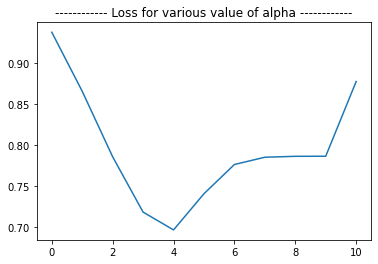

In [40]:
plt.title("------------ Loss for various value of alpha ------------")
plt.plot(lossMNB)
plt.show()

In [41]:
print("the least value of log-loss is ",min(lossMNB),"with the best value for alpha is : ", alphaNB[np.argmin(lossMNB)])

the least value of log-loss is  0.6966226819260518 with the best value for alpha is :  10


In [42]:
# training model with best alpha value
MNB = MultinomialNB(alpha=10)
MNB.fit(x_train,y_train)

sig_clf = CalibratedClassifierCV(MNB, method="sigmoid",n_jobs=5)
sig_clf.fit(x_train,y_train)

MNB_probs_train = sig_clf.predict_proba(x_train)
MNB_probs_cv = sig_clf.predict_proba(x_cv)
MNB_probs_test = sig_clf.predict_proba(x_test)

print("Log-Loss for train data : ",log_loss(y_train, MNB_probs_train, eps=1e-15) )
print("Log-Loss for cross validation data : ",log_loss(y_cv, MNB_probs_cv, eps=1e-15) )
print("Log-Loss test data : ",log_loss(y_test, MNB_probs_test, eps=1e-15) )

Log-Loss for train data :  0.6394483264019881
Log-Loss for cross validation data :  0.6966226819260518
Log-Loss test data :  0.7038369769436112


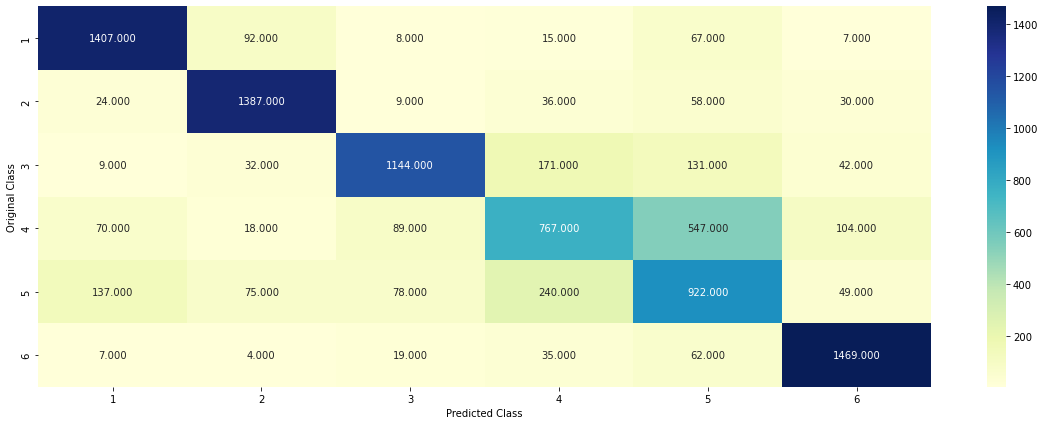

In [43]:
MNB_pred_test = []
for i in MNB_probs_test:
    MNB_pred_test.append(np.argmax(i))
plot_confusion_matrix(y_test,MNB_pred_test)

### so here we can conclude that TF-IDF features is bit more helpful in classifying the target variable than the BOW features.

# <center>Training a simple Naive Bayes only on TF-IDF weighted word2vec features.

In [58]:
df_w2v = pd.DataFrame(df.text_w2v.values.tolist(), index= df.index)

df_W2V = df.merge(df_w2v, left_index=True, right_index=True,how='left')
df_W2V.drop("text_w2v",axis=1,inplace=True)
df_W2V.head()

cyberbullying_type                                  text_preprocessed  \
0  not_cyberbullying                 word katandandr food crapilici mkr   
1  not_cyberbullying   whi aussietv white mkr theblock imacelebritya...   
2  not_cyberbullying                     classi whore red velvet cupcak   
3  not_cyberbullying    meh thank head concern anoth angri dude twitter   
4  not_cyberbullying   thi isi account pretend kurdish account like ...   

           0          1          2          3          4          5  \
0  42.008400 -20.947382 -31.739697  -2.875196  22.078381 -64.988150   
1 -40.574400 -52.789725 -13.945453  -9.321242  53.497053 -19.826501   
2 -99.661478  -5.295562 -50.971367  57.720614   1.740670 -63.959061   
3  59.483592  -0.117731 -57.738265  16.406347  79.366356   1.413348   
4 -29.614999  -7.757767 -50.577355   4.407575  69.451913  62.789721   

           6           7  ...        290        291        292        293  \
0  -6.565864    8.241677  ...  52.026989   1.571356  44.467997 -81.590988   
1   8.263075   54.945669  ... -66.734128  14.506146  16.386640 -88.546642   
2 -18.727083   37.121094  ...  13.226023  74.716227  76.261179 -42.175050   
3 -28.628779   61.562790  ...  71.760499 -32.296366 -21.931568  -7.694682   
4  25.808911  118.790315  ...  60.590302 -39.818573  54.024486   1.916959   

          294        295        296        297        298        299  
0  -36.487601 -67.955723  40.968580  -6.394960 -51.339858  14.072126  
1    0.313842 -38.434055 -39.813414 -13.878941 -48.545671  22.818656  
2  -30.412297  59.798174  75.609328  57.605323 -47.964400 -39.160646  
3  -59.308900   4.483792  83.150791  26.864769 -47.034821  41.424901  
4 -116.316367  25.997620  30.544699  -0.009724 -76.358538  48.921424  

[5 rows x 302 columns]

In [59]:
# label encoding the target feature 
labelencoder=LabelEncoder()
df_W2V['cyberbullying_type']=labelencoder.fit_transform(df_W2V['cyberbullying_type'])

In [60]:
print("Number of null values after tf-idf weighted word2vec : ",df_W2V.isna().sum().sum())
df_W2V = df_W2V.dropna()
print("dataset shape after droping null ", df_W2V.shape)

x = df_W2V.drop(['cyberbullying_type','text_preprocessed'],axis=1)
y = df_W2V['cyberbullying_type']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

Number of null values after BOW :  0
dataset shape after droping null  (47248, 302)


In [71]:
#scaling the value of independent variable so as to build a KNN model
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_cv_scaled = scaler.transform(x_cv)
x_test_scaled = scaler.transform(x_test)

In [75]:
kvalues = []
for x in range(1,30):
    if x%2 != 0:
        kvalues.append(x)
        
lossknn = []
for k in kvalues:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x_train_scaled,y_train)
    
    #calibarated classifiers for getting the actual probability score
    sig_clf = CalibratedClassifierCV(neigh, method="sigmoid",n_jobs=5)
    sig_clf.fit(x_train_scaled,y_train)
    neigh_probs = sig_clf.predict_proba(x_cv_scaled)
    
    #append the loss for different alpha value
    lossknn.append(log_loss(y_cv, neigh_probs, eps=1e-15))
    print("Log-Loss for k value ", k , " is : ",log_loss(y_cv, neigh_probs, eps=1e-15) )

Log-Loss for alpha value  1  is :  1.245568987123081
Log-Loss for alpha value  3  is :  1.088488036322651
Log-Loss for alpha value  5  is :  1.0270955353005475
Log-Loss for alpha value  7  is :  0.9962657942145494
Log-Loss for alpha value  9  is :  0.975916577144081
Log-Loss for alpha value  11  is :  0.9632487096420715
Log-Loss for alpha value  13  is :  0.9544388442216072
Log-Loss for alpha value  15  is :  0.9478064972880449
Log-Loss for alpha value  17  is :  0.944161994044494
Log-Loss for alpha value  19  is :  0.9411364172439219
Log-Loss for alpha value  21  is :  0.9377710970232254
Log-Loss for alpha value  23  is :  0.9369903752958064
Log-Loss for alpha value  25  is :  0.935912873886631
Log-Loss for alpha value  27  is :  0.9365423896410653
Log-Loss for alpha value  29  is :  0.9373308044533676


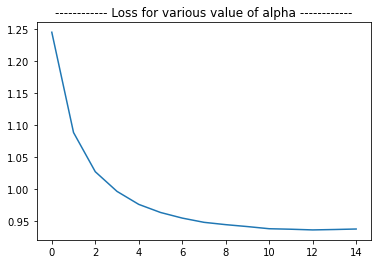

In [77]:
plt.title("------------ Loss for various value of alpha ------------")
plt.plot(lossknn)
plt.show()

### <center>so here we can conclude that TF-IDF weighted word2vec features is definitely helpful in classifying the target variable.

### There is high chance that by mereging both tf-idf and TF-IDF weighted word2vec we can build much rigorous models.  Lets try out with much complex models on merged data set.

In [82]:
df_TFIDF.drop('text_preprocessed',axis=1,inplace=True)
df_W2V.drop(['text_preprocessed','cyberbullying_type'],axis=1,inplace=True)

df_final = df_TFIDF.merge(df_W2V,left_index=True, right_index=True)
df_final.head()

cyberbullying_type   00   10  100  1000  100k  10k  10th  10x  10yearold  \
0                   3  0.0  0.0  0.0   0.0   0.0  0.0   0.0  0.0        0.0   
1                   3  0.0  0.0  0.0   0.0   0.0  0.0   0.0  0.0        0.0   
2                   3  0.0  0.0  0.0   0.0   0.0  0.0   0.0  0.0        0.0   
3                   3  0.0  0.0  0.0   0.0   0.0  0.0   0.0  0.0        0.0   
4                   3  0.0  0.0  0.0   0.0   0.0  0.0   0.0  0.0        0.0   

   ...        290        291        292        293         294        295  \
0  ...  52.026989   1.571356  44.467997 -81.590988  -36.487601 -67.955723   
1  ... -66.734128  14.506146  16.386640 -88.546642    0.313842 -38.434055   
2  ...  13.226023  74.716227  76.261179 -42.175050  -30.412297  59.798174   
3  ...  71.760499 -32.296366 -21.931568  -7.694682  -59.308900   4.483792   
4  ...  60.590302 -39.818573  54.024486   1.916959 -116.316367  25.997620   

         296        297        298        299  
0  40.968580  -6.394960 -51.339858  14.072126  
1 -39.813414 -13.878941 -48.545671  22.818656  
2  75.609328  57.605323 -47.964400 -39.160646  
3  83.150791  26.864769 -47.034821  41.424901  
4  30.544699  -0.009724 -76.358538  48.921424  

[5 rows x 10524 columns]

In [83]:
df_final.shape

(46805, 10524)

In [84]:
df_final.to_csv("cyberbulling_features.csv", index=False)